# Theft From Motor Vehicle 

In [85]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

### Functions

In [86]:
def check_missing_value(df):
    missing_values = df.isnull().sum()
    print("Missing Values:")
    print(missing_values[missing_values > 0])

In [87]:
def handle_missing(df):
    #global crime_data  # Accessing the global variable within the function

    # Handling missing values
    missing_year = df['OCC_YEAR'].isna()
    missing_month = df['OCC_MONTH'].isna()
    missing_day = df['OCC_DAY'].isna()
    missing_doy = df['OCC_DOY'].isna()
    missing_dow = df['OCC_DOW'].isna()
    
    df.loc[missing_year, 'OCC_YEAR'] = pd.to_datetime(df.loc[missing_year, 'OCC_DATE']).dt.year
    df.loc[missing_month, 'OCC_MONTH'] = pd.to_datetime(df.loc[missing_month, 'OCC_DATE']).dt.month
    df.loc[missing_day, 'OCC_DAY'] = pd.to_datetime(df.loc[missing_day, 'OCC_DATE']).dt.day
    df.loc[missing_doy, 'OCC_DOY'] = pd.to_datetime(df.loc[missing_doy, 'OCC_DATE']).dt.dayofyear
    df.loc[missing_dow, 'OCC_DOW'] = pd.to_datetime(df.loc[missing_dow, 'OCC_DATE']).dt.dayofweek
    df = df[~df['OCC_DOW'].apply(lambda x: isinstance(x, int))]
    
    return df

In [88]:
def check_duplicate(df):
    duplicate_rows = df[df.duplicated()]
    print("\nDuplicate rows:")
    print(duplicate_rows)
    return duplicate_rows

### Load dataset

In [89]:
# URL of the CSV file
url_dataset = "https://opendata.arcgis.com/api/v3/datasets/d9303bc20f8a4351b7744a8703eecb80_0/downloads/data?format=csv&spatialRefId=3857&where=1%3D1"

# Read CSV data from the URL
crime_data = pd.read_csv(url_dataset)

# Get the row and column count 
print(crime_data.shape)

(88462, 31)


In [90]:
# Display the first few rows of the dataset
crime_data.head(5)

,X,Y,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,...,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,-8.841386e+06,5.413457e+06,1,GO-20141263375,2014/01/01 05:00:00+00,2013/12/31 05:00:00+00,2014,January,1,1,...,2142,200,Theft From Motor Vehicle Under,NonMCI,172,Dovercourt Village,93,Dovercourt-Wallace Emerson-Junction (93),-79.423518,43.663124
1,-8.835455e+06,5.418266e+06,2,GO-20141260616,2014/01/01 05:00:00+00,2014/01/01 05:00:00+00,2014,January,1,1,...,2142,200,Theft From Motor Vehicle Under,NonMCI,56,Leaside-Bennington,56,Leaside-Bennington (56),-79.370241,43.694370
2,-8.844274e+06,5.423381e+06,3,GO-20149000010,2014/01/01 05:00:00+00,2013/12/31 05:00:00+00,2014,January,1,1,...,2142,200,Theft From Motor Vehicle Under,NonMCI,31,Yorkdale-Glen Park,31,Yorkdale-Glen Park (31),-79.449470,43.727581
3,-8.849275e+06,5.422602e+06,4,GO-20141262668,2014/01/01 05:00:00+00,2013/12/31 05:00:00+00,2014,January,1,1,...,2142,200,Theft From Motor Vehicle Under,NonMCI,154,Oakdale-Beverley Heights,26,Downsview-Roding-CFB (26),-79.494388,43.722524
4,-8.838696e+06,5.410273e+06,5,GO-20141261604,2014/01/01 05:00:00+00,2013/12/31 05:00:00+00,2014,January,1,1,...,2142,200,Theft From Motor Vehicle Under,NonMCI,164,Wellington Place,77,Waterfront Communities-The Island (77),-79.399355,43.642429


In [91]:
# Display basic information about the dataset
print(crime_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88462 entries, 0 to 88461
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  88462 non-null  float64
 1   Y                  88462 non-null  float64
 2   OBJECTID           88462 non-null  int64  
 3   EVENT_UNIQUE_ID    88462 non-null  object 
 4   REPORT_DATE        88462 non-null  object 
 5   OCC_DATE           88462 non-null  object 
 6   REPORT_YEAR        88462 non-null  int64  
 7   REPORT_MONTH       88462 non-null  object 
 8   REPORT_DAY         88462 non-null  int64  
 9   REPORT_DOY         88462 non-null  int64  
 10  REPORT_DOW         88462 non-null  object 
 11  REPORT_HOUR        88462 non-null  int64  
 12  OCC_YEAR           88443 non-null  float64
 13  OCC_MONTH          88443 non-null  object 
 14  OCC_DAY            88443 non-null  float64
 15  OCC_DOY            88443 non-null  float64
 16  OCC_DOW            884

In [92]:
# Check for missing values
check_missing_value(crime_data)

Missing Values:
OCC_YEAR     19
OCC_MONTH    19
OCC_DAY      19
OCC_DOY      19
OCC_DOW      19
dtype: int64


### Data Cleaning

In [93]:
# Remove unwanted Columns
crime_data = crime_data.drop(columns = ['EVENT_UNIQUE_ID', 'UCR_CODE'])

In [94]:
# Handling missing values
#crime_data.dropna(inplace = True)
crime_data = handle_missing(crime_data)

In [95]:
# Correct data types
crime_data['REPORT_DATE'] = pd.to_datetime(crime_data['REPORT_DATE'])
crime_data['OCC_DATE'] = pd.to_datetime(crime_data['OCC_DATE'])

In [96]:
# Convert categorical variables to appropriate data types
crime_data['LOCATION_TYPE'] = crime_data['LOCATION_TYPE'].astype('category')


Z-score:
 0        0.760166
1       -2.204833
2       -2.600166
3        0.167166
4       -0.821167
           ...   
88457   -0.030501
88458    0.364833
88459   -0.425834
88460    1.155499
88461   -0.425834
Name: REPORT_HOUR, Length: 88443, dtype: float64



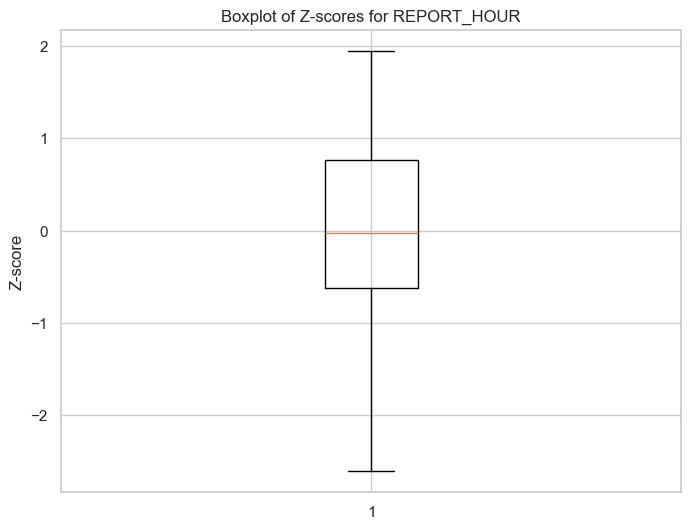

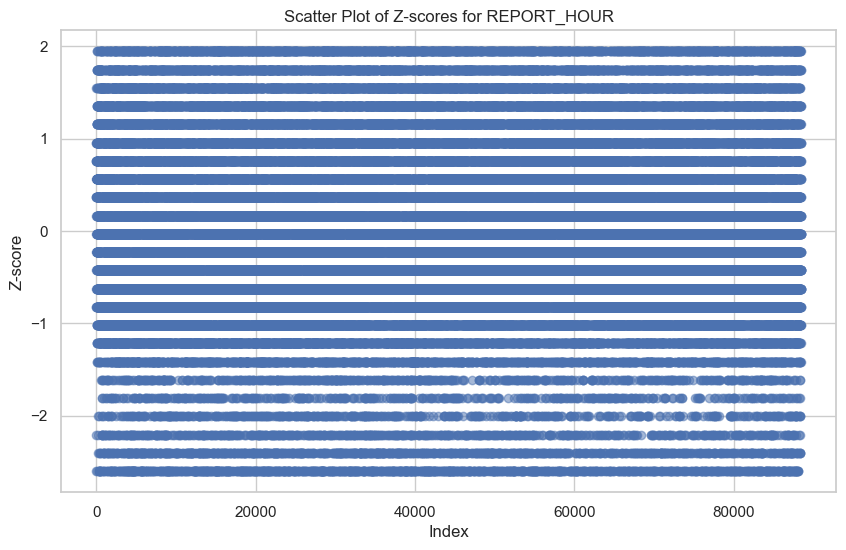

In [97]:
# Dealing with outliers (if needed)
# Example: Removing outliers in REPORT_HOUR using z-score
z_scores = zscore(crime_data['REPORT_HOUR'])
print("\nZ-score:\n", z_scores)
print()

# Create a boxplot for z-scores
plt.figure(figsize=(8, 6))
plt.boxplot(z_scores)
plt.title('Boxplot of Z-scores for REPORT_HOUR')
plt.ylabel('Z-score')
plt.show()

# Create a scatter plot for z-scores
plt.figure(figsize=(10, 6))
plt.scatter(x=crime_data.index, y=z_scores, alpha=0.5)
plt.title('Scatter Plot of Z-scores for REPORT_HOUR')
plt.xlabel('Index')
plt.ylabel('Z-score')
plt.grid(True)
plt.show()

# apply filter to the dataset according to z-score value to neglate outliers
crime_data = crime_data[(z_scores < 3) & (z_scores > -3)]

In [98]:
# Verify changes
print("\nCleaned Data Information:")
print(crime_data.info())


Cleaned Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 88443 entries, 0 to 88461
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   X                  88443 non-null  float64            
 1   Y                  88443 non-null  float64            
 2   OBJECTID           88443 non-null  int64              
 3   REPORT_DATE        88443 non-null  datetime64[ns, UTC]
 4   OCC_DATE           88443 non-null  datetime64[ns, UTC]
 5   REPORT_YEAR        88443 non-null  int64              
 6   REPORT_MONTH       88443 non-null  object             
 7   REPORT_DAY         88443 non-null  int64              
 8   REPORT_DOY         88443 non-null  int64              
 9   REPORT_DOW         88443 non-null  object             
 10  REPORT_HOUR        88443 non-null  int64              
 11  OCC_YEAR           88443 non-null  float64            
 12  OCC_MONTH          88443

In [99]:
# Check for missing values after cleanup
check_missing_value(crime_data)

Missing Values:
Series([], dtype: int64)


In [100]:
# Remove Duplicates
duplicate_rows = check_duplicate(crime_data)
crime_data.drop_duplicates(inplace=True)


Duplicate rows:
Empty DataFrame
Columns: [X, Y, OBJECTID, REPORT_DATE, OCC_DATE, REPORT_YEAR, REPORT_MONTH, REPORT_DAY, REPORT_DOY, REPORT_DOW, REPORT_HOUR, OCC_YEAR, OCC_MONTH, OCC_DAY, OCC_DOY, OCC_DOW, OCC_HOUR, DIVISION, LOCATION_TYPE, PREMISES_TYPE, UCR_EXT, OFFENCE, MCI_CATEGORY, HOOD_158, NEIGHBOURHOOD_158, HOOD_140, NEIGHBOURHOOD_140, LONG_WGS84, LAT_WGS84]
Index: []

[0 rows x 29 columns]


In [101]:
# Scaling/Normalization
scaler = MinMaxScaler()
crime_data[['LONG_WGS84', 'LAT_WGS84']] = scaler.fit_transform(crime_data[['LONG_WGS84', 'LAT_WGS84']])

In [102]:
## Summary Statistics
summary_stats = crime_data[['REPORT_HOUR']].describe()
print("\n", summary_stats)


         REPORT_HOUR
count  88443.000000
mean      13.154303
std        5.059052
min        0.000000
25%       10.000000
50%       13.000000
75%       17.000000
max       23.000000


### Data Visualizations

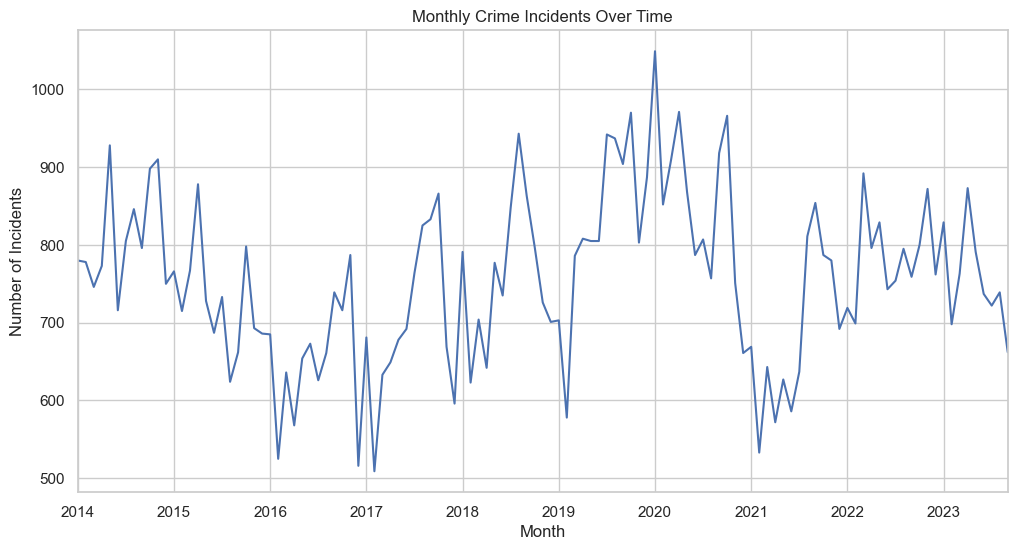

In [103]:
# Temporal Trends according to report date
plt.figure(figsize=(12, 6))
crime_data.resample('M', on='REPORT_DATE').size().plot()
plt.title('Monthly Crime Incidents Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


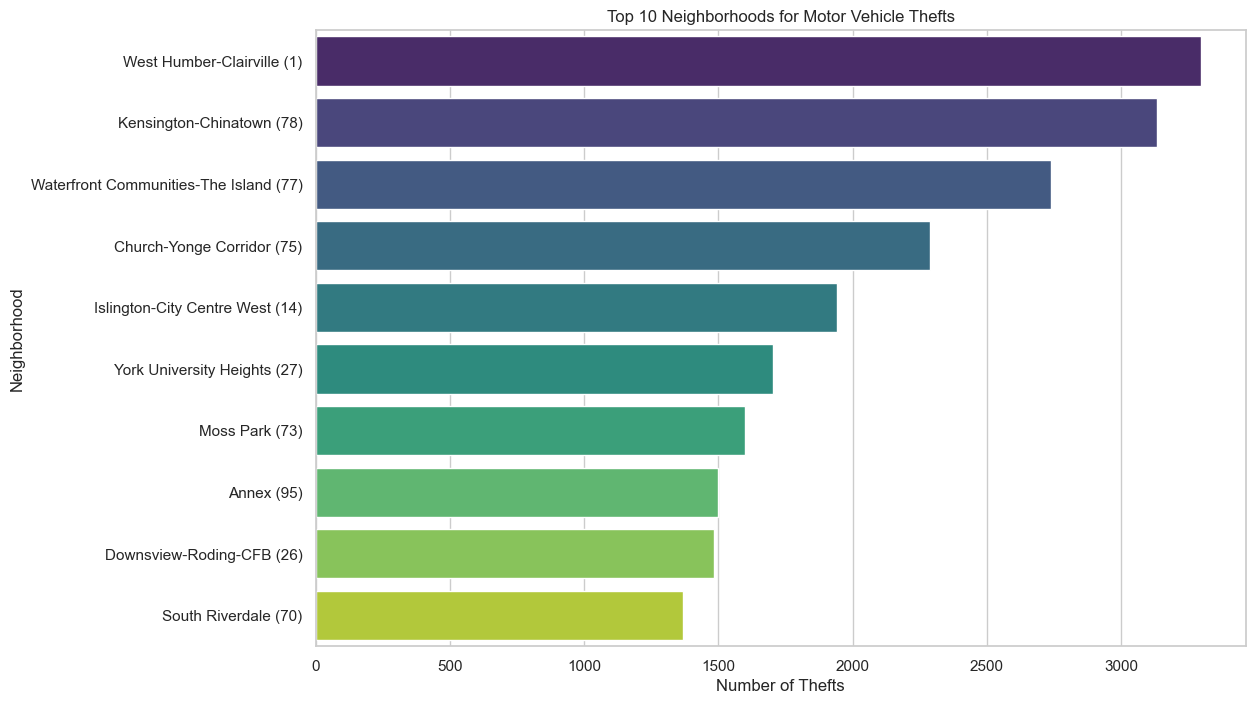

In [104]:
#---------- Bar chart – top 10 neighbours of theft motor vehicles ----------------

# Aggregate data to count thefts by neighborhood
neighborhood_counts = crime_data['NEIGHBOURHOOD_140'].value_counts().reset_index(name='Theft_Count')

# Sort the data to get the top 10 neighborhoods
top_10_neighborhoods = neighborhood_counts.sort_values(by='Theft_Count', ascending=False).head(10)

# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Theft_Count', y='NEIGHBOURHOOD_140', data=top_10_neighborhoods, palette='viridis')

# Customize the plot
plt.title('Top 10 Neighborhoods for Motor Vehicle Thefts')
plt.xlabel('Number of Thefts')
plt.ylabel('Neighborhood')

# Show the plot
plt.show()

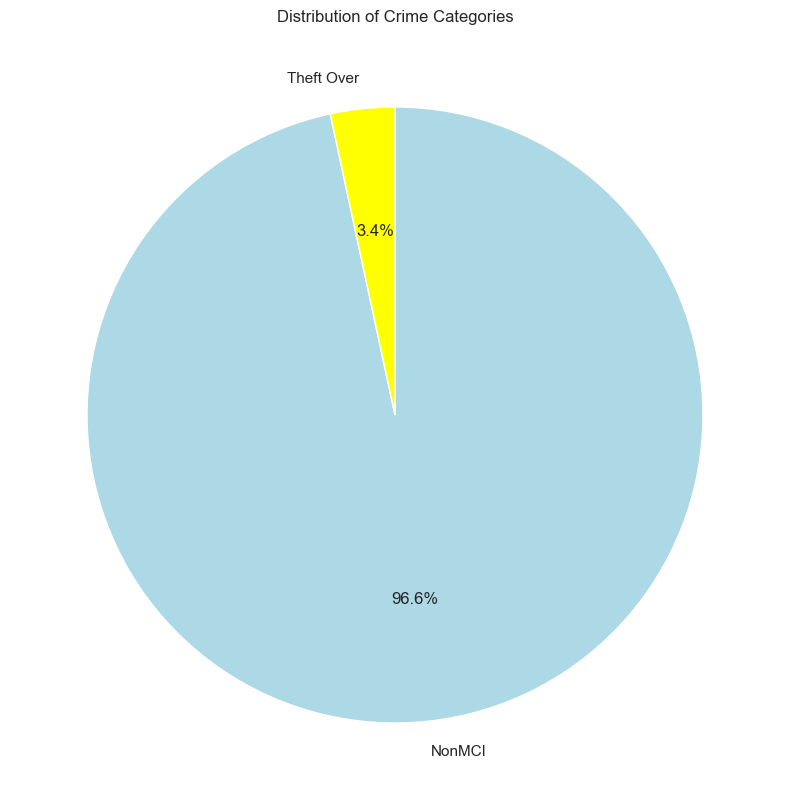

In [105]:
## Frequency of Crime Categories
# Calculate the distribution of crime categories
crime_category_counts = crime_data['MCI_CATEGORY'].value_counts()
# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(crime_category_counts, labels=crime_category_counts.index, autopct='%1.1f%%', startangle=90, counterclock=False, colors = ['lightblue', 'yellow'])
plt.title('Distribution of Crime Categories')
plt.show()

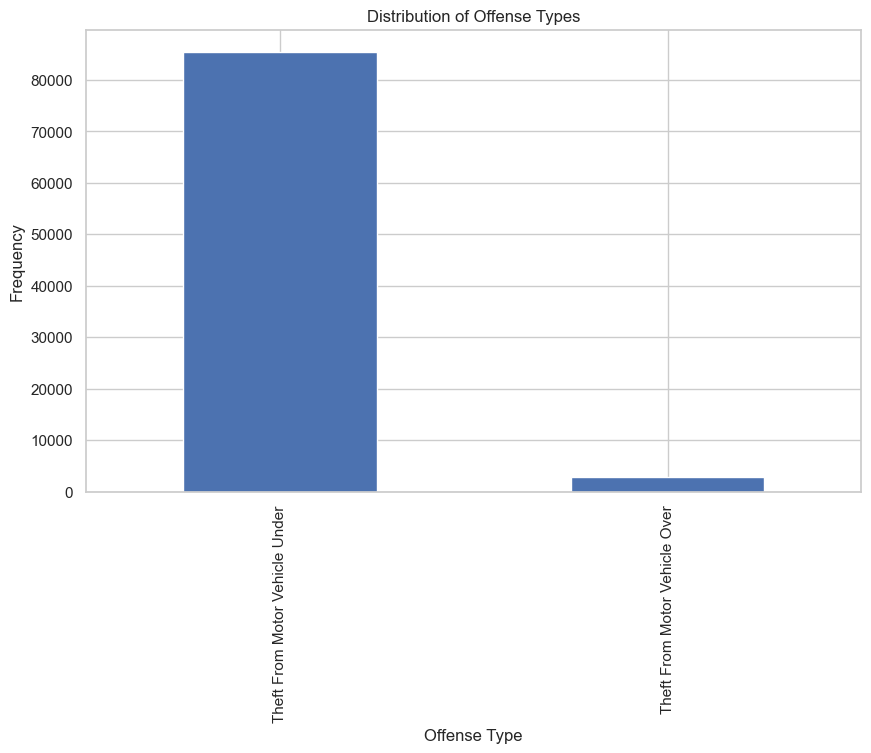

In [106]:
# Histogram of offense types
plt.figure(figsize=(10, 6))
crime_data['OFFENCE'].value_counts().plot(kind='bar')
plt.title('Distribution of Offense Types')
plt.xlabel('Offense Type')
plt.ylabel('Frequency')
plt.show()

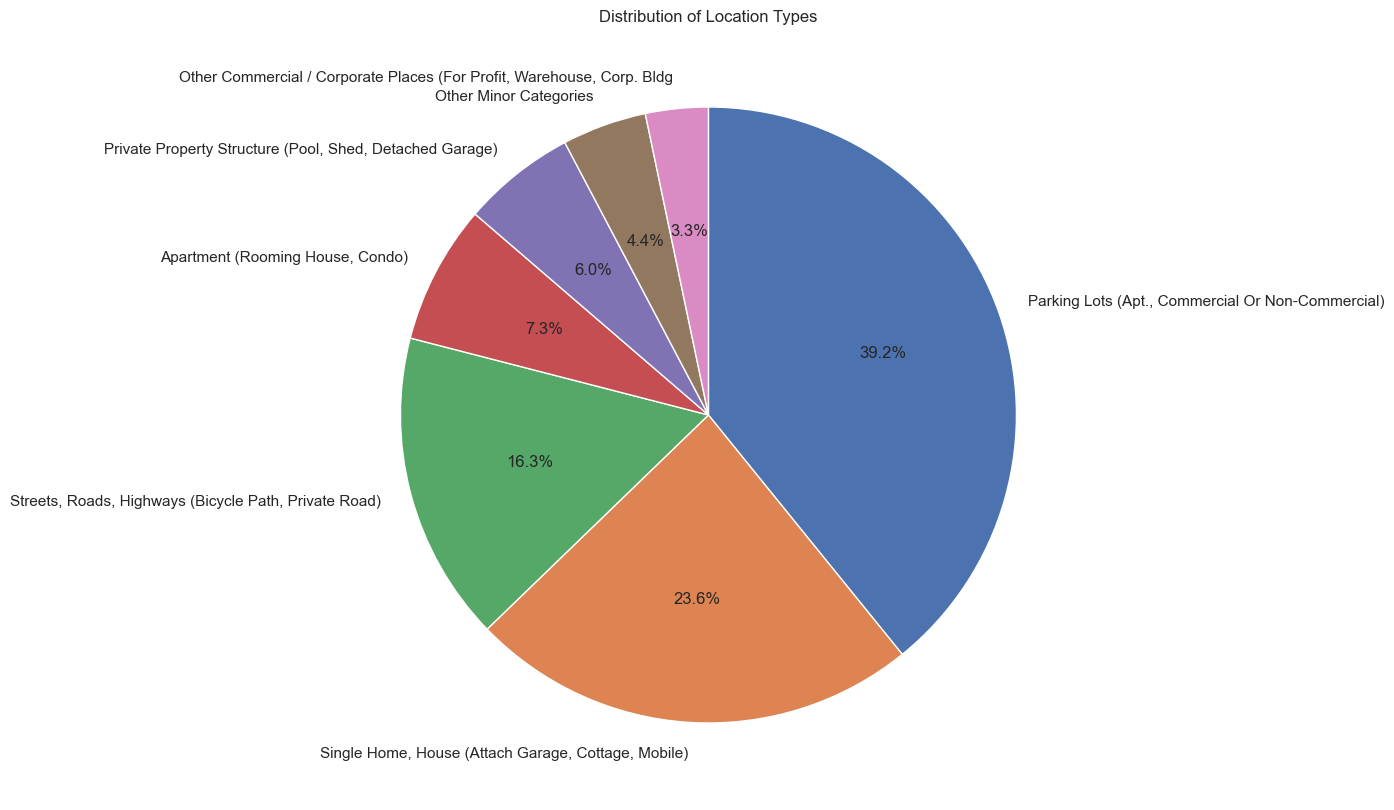

In [107]:
# Pie chart - Location Type
location_data = crime_data
location_counts = location_data['LOCATION_TYPE'].value_counts()
# Identify categories with less than 3% data
minor_categories = location_counts[(location_counts / sum(location_counts)) < 0.01].index
# Replace those categories with 'Other'
location_data['LOCATION_TYPE'] = location_data['LOCATION_TYPE'].replace(minor_categories, 'Other Minor Categories')
# Recalculate counts after merging small categories
location_counts_updated = location_data['LOCATION_TYPE'].value_counts()
# Plotting the pie chart
plt.figure(figsize=(10, 10))
plt.pie(location_counts_updated, labels = location_counts_updated.index, autopct = '%1.1f%%', startangle = 90, counterclock = False)
plt.title('Distribution of Location Types')
plt.show()

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

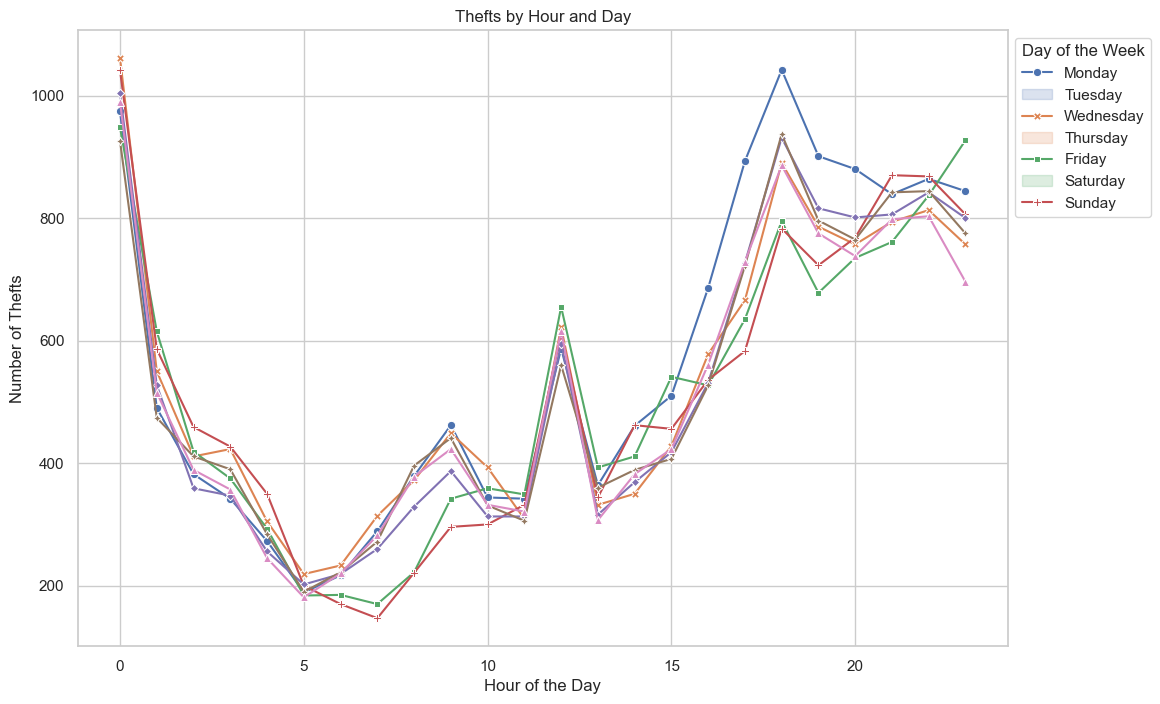

In [108]:
# ---------- Line chart for occurred thefts by hours & day ---------------------

# Aggregate data to count thefts by hour and day
hour_day_counts = crime_data.groupby(['OCC_HOUR', 'OCC_DOW']).size().reset_index(name='Theft_Count')

# Pivot the data to create a table suitable for plotting
hour_day_pivot = hour_day_counts.pivot(index='OCC_HOUR', columns='OCC_DOW', values='Theft_Count')

# Define the order of days for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a line chart
plt.figure(figsize=(12, 8))
sns.lineplot(data=hour_day_pivot, dashes=False, markers=True)

# Customize the plot
plt.title('Thefts by Hour and Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Thefts')
plt.legend(title='Day of the Week', labels=day_order, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


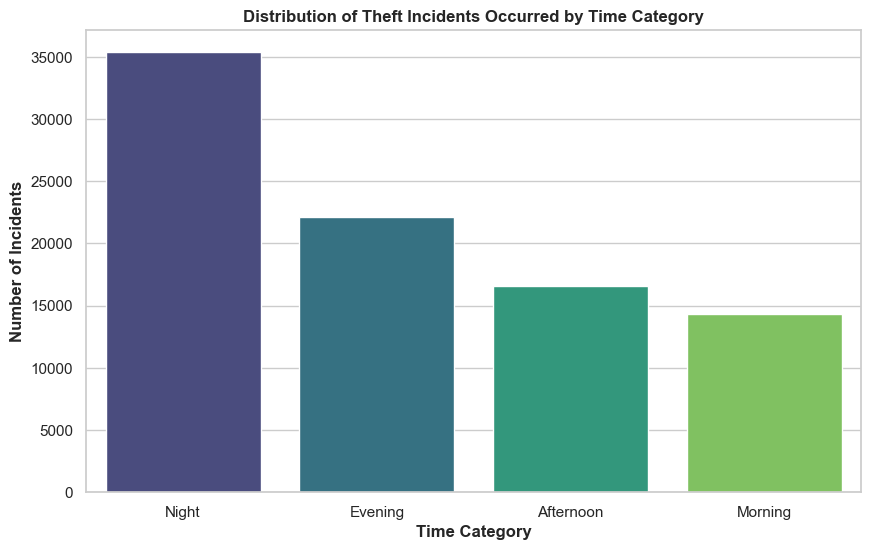

In [109]:
# ------------ Subset of morning, afternoon, afternoon, evening, night -------------------

def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the categorization to create a new column 'TIME_CATEGORY'
crime_data['TIME_CATEGORY'] = crime_data['OCC_HOUR'].apply(categorize_time)

# Count the occurrences of each category
time_category_counts = crime_data['TIME_CATEGORY'].value_counts()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a bar chart using seaborn
sns.barplot(x=time_category_counts.index, y=time_category_counts.values, palette='viridis')

# Customize the plot
plt.title('Distribution of Theft Incidents Occurred by Time Category', fontweight='bold')
plt.xlabel('Time Category', fontweight='bold')
plt.ylabel('Number of Incidents' , fontweight='bold')

# Show the plot
plt.show()

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


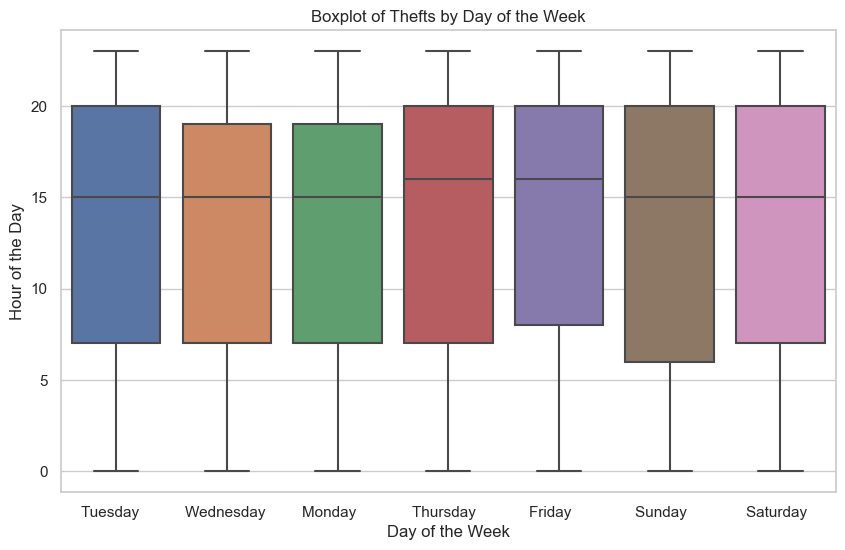

In [110]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='OCC_DOW', y='OCC_HOUR', data=crime_data)
plt.title('Boxplot of Thefts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')
plt.show()

In [111]:
# Calculate number of cases by hour of the day
hourly_thefts = crime_data.groupby('OCC_HOUR').size()
hourly_thefts

OCC_HOUR
0     6943
1     3757
2     2830
3     2661
4     2006
5     1365
6     1466
7     1734
8     2297
9     2800
10    2372
11    2272
12    4247
13    2416
14    2824
15    3183
16    3946
17    4955
18    6264
19    5475
20    5444
21    5710
22    5871
23    5605
dtype: int64

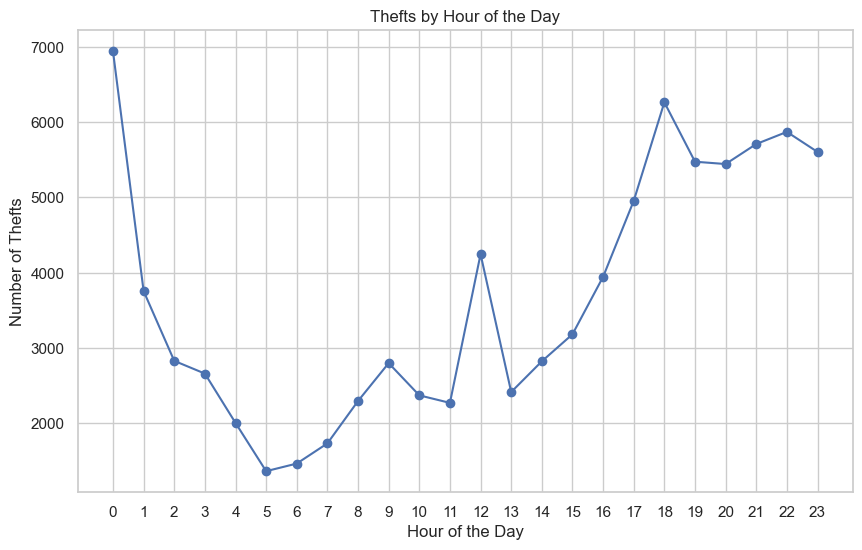

In [112]:
# Plotting
plt.figure(figsize=(10, 6))
hourly_thefts.plot(kind='line', marker='o')
plt.title('Thefts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Thefts')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

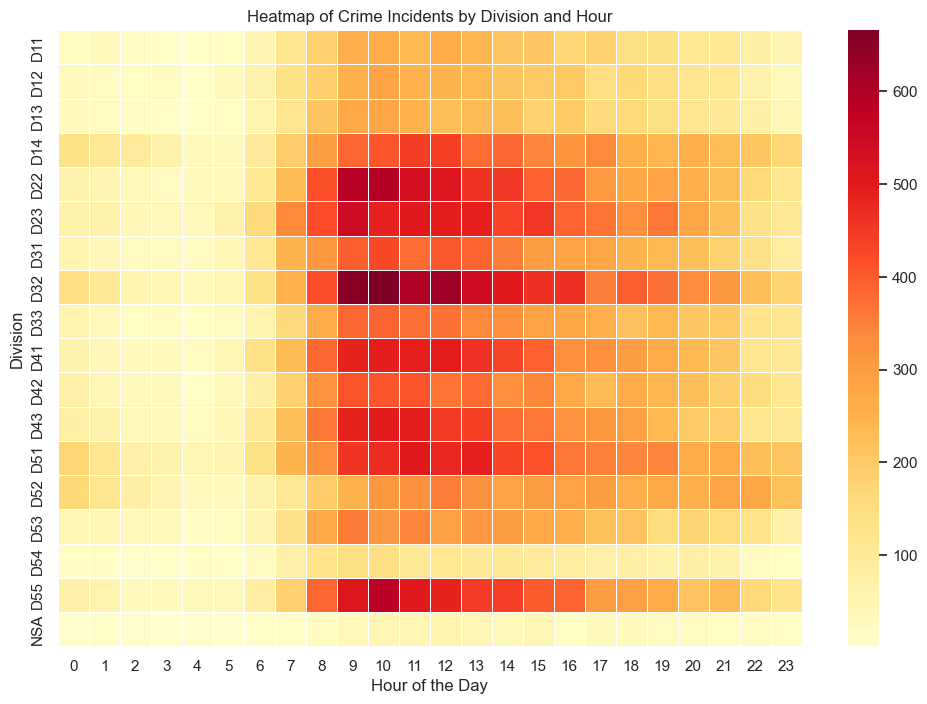

In [113]:
#Heatmap of Crime Incidents by Division and Hour
pivot_table = crime_data.pivot_table(index='DIVISION', columns='REPORT_HOUR', values='OBJECTID', aggfunc='count')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', linewidths=.5)
plt.title('Heatmap of Crime Incidents by Division and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Division')
plt.show()

/var/folders/vt/gdk5223s7sb29xlr_0q4v9580000gn/T/ipykernel_19134/3962883216.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = crime_data.groupby(['REPORT_YEAR', 'REPORT_MONTH']).size().unstack()


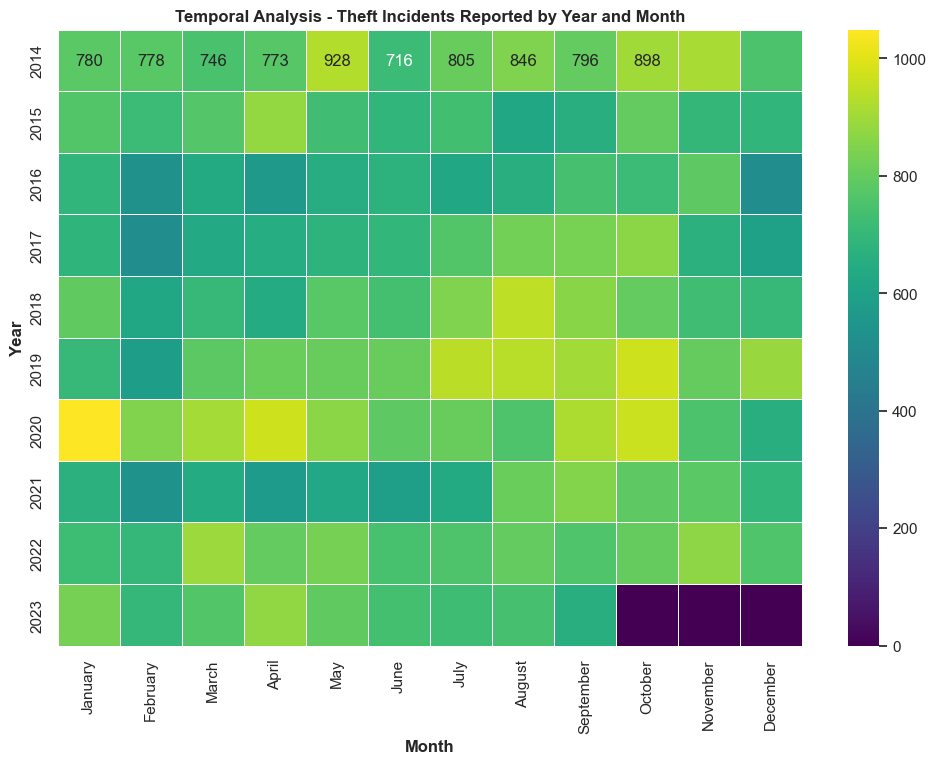

In [114]:
# ------------ Heatmap for report_year & report_month -------------------------

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Convert 'REPORT_MONTH' to a categorical type with custom order
crime_data['REPORT_MONTH'] = pd.Categorical(crime_data['REPORT_MONTH'], categories=month_order, ordered=True)

heatmap_data = crime_data.groupby(['REPORT_YEAR', 'REPORT_MONTH']).size().unstack()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.0f', linewidths=.5)

# Customize the plot
plt.title('Temporal Analysis - Theft Incidents Reported by Year and Month', fontweight='bold')
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Year', fontweight='bold')

# Show the plot
plt.show()


### Clustering Model

##### Building clustering model

In [115]:
# Set the style of the plots
sns.set(style = "whitegrid")

In [116]:
# Apply label encoding for categorical time-based features
label_encoder_dow = LabelEncoder()
crime_data['OCC_DOW_encoded'] = label_encoder_dow.fit_transform(crime_data['OCC_DOW'])

label_encoder_month = LabelEncoder()
crime_data['OCC_MONTH_encoded'] = label_encoder_month.fit_transform(crime_data['OCC_MONTH'])

In [117]:
# Using 'REPORT_HOUR', 'REPORT_DOW_encoded', and 'REPORT_MONTH_encoded' for clustering
time_clustering_features = crime_data[['OCC_HOUR', 'OCC_DOW_encoded', 'OCC_MONTH_encoded']]
time_clustering_features.head()

,OCC_HOUR,OCC_DOW_encoded,OCC_MONTH_encoded
0,23,5,2
1,2,6,4
2,15,5,2
3,18,5,2
4,16,5,2


In [118]:
# Normalizing the features
time_clustering_scaled = scaler.fit_transform(time_clustering_features)

In [119]:
# Elbow Method to find the optimal number of clusters
inertia_time = []
range_clusters_time = range(1, 11)  # Testing 1 to 10 clusters

for k in range_clusters_time:
    kmeans_time = KMeans(n_clusters=k, random_state=42)
    kmeans_time.fit(time_clustering_scaled)
    inertia_time.append(kmeans_time.inertia_)

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

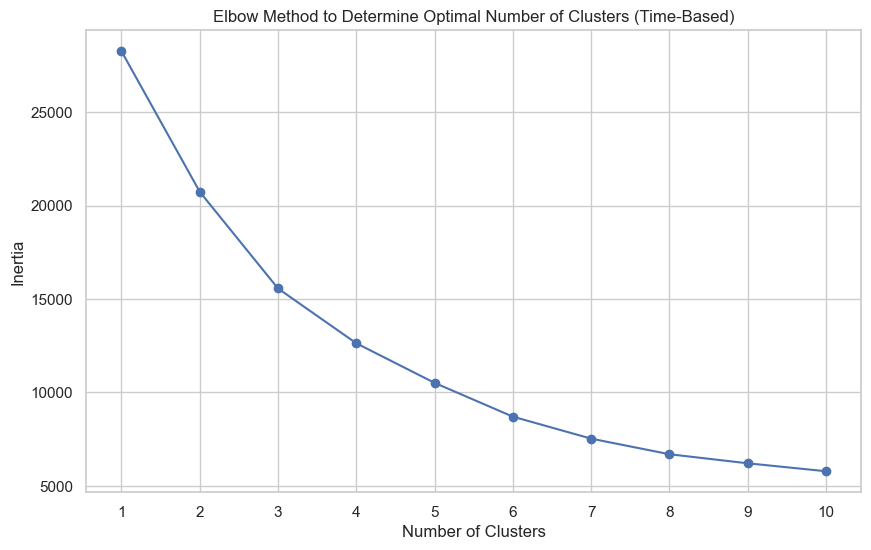

In [120]:
# Plotting the Elbow graph for time-based clustering
plt.figure(figsize=(10, 6))
plt.plot(range_clusters_time, inertia_time, marker='o')
plt.title('Elbow Method to Determine Optimal Number of Clusters (Time-Based)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_clusters_time)
plt.show()

In [121]:
# Reapply K-Means clustering with the chosen number of clusters for time-based features
optimal_clusters_time = 4
kmeans_time = KMeans(n_clusters=optimal_clusters_time, random_state=42)
time_clusters = kmeans_time.fit_predict(time_clustering_scaled)

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [122]:
# Adding the cluster information to the original data for analysis
crime_data['Time_Cluster'] = time_clusters

# Viewing the first few rows with the time cluster assignments
crime_data[['OCC_MONTH','OCC_MONTH_encoded', 'OCC_DOW', 'OCC_DOW_encoded']]

,OCC_MONTH,OCC_MONTH_encoded,OCC_DOW,OCC_DOW_encoded
0,December,2,Tuesday,5
1,January,4,Wednesday,6
2,December,2,Tuesday,5
3,December,2,Tuesday,5
4,December,2,Tuesday,5
...,...,...,...,...
88457,September,11,Saturday,2
88458,September,11,Saturday,2
88459,September,11,Saturday,2
88460,September,11,Friday,0


In [123]:
# Calculating the centroids of the clusters
centroids = kmeans_time.cluster_centers_

# Inverse transform the centroids to get them back to the original scale
centroids_original_scale = scaler.inverse_transform(centroids)
centroids_original_scale

array([[ 2.61432747,  3.1323677 ,  5.49749138],
       [16.59642421,  1.54380603,  2.20181337],
       [17.15912409,  5.03422973,  5.6823665 ],
       [16.80478348,  1.41898288,  8.80110775]])

In [124]:
# Creating a DataFrame for the centroids for easier interpretation
centroids_df = pd.DataFrame(centroids_original_scale, columns=['OCC_HOUR_Centroid', 'OCC_DOW_Centroid', 'OCC_MONTH_Centroid'])

# Rounding the values for better readability
centroids_df = centroids_df.round(2)

In [125]:
# Mapping the inverse transform of encoded values back to actual days and months
centroids_df['OCC_DOW_Centroid'] = centroids_df['OCC_DOW_Centroid'].apply(lambda x: label_encoder_dow.inverse_transform([int(round(x))])[0])
centroids_df['OCC_MONTH_Centroid'] = centroids_df['OCC_MONTH_Centroid'].apply(lambda x: label_encoder_month.inverse_transform([int(round(x))])[0])

centroids_df

,OCC_HOUR_Centroid,OCC_DOW_Centroid,OCC_MONTH_Centroid
0,2.61,Sunday,June
1,16.60,Saturday,December
2,17.16,Tuesday,June
3,16.80,Monday,November


/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

AttributeError: 'numpy.int32' object has no attribute 'startswith'

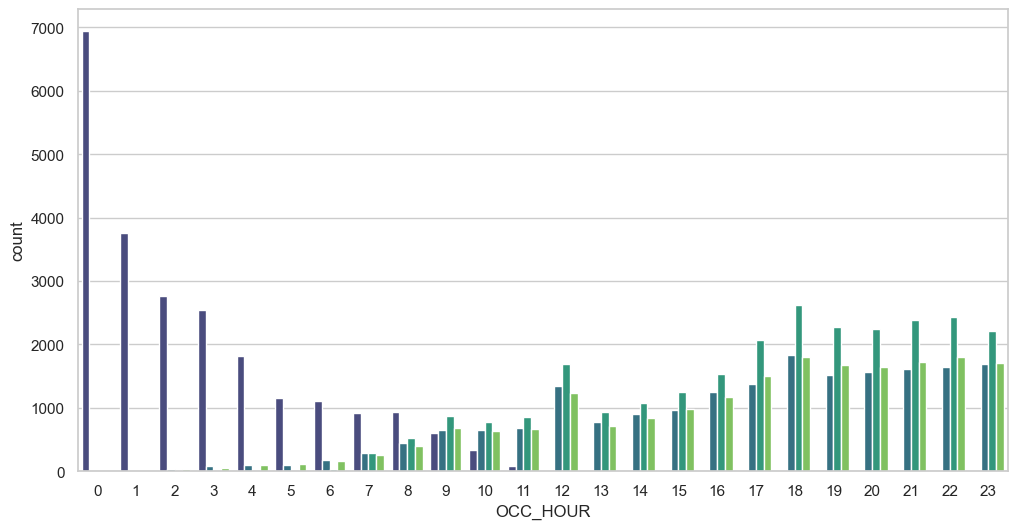

In [126]:
# Plotting the cluster distribution by hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(x='OCC_HOUR', hue='Time_Cluster', data=crime_data, palette='viridis')
plt.title('Cluster Distribution by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend(title='Time Cluster')
plt.show()

/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


AttributeError: 'numpy.int32' object has no attribute 'startswith'

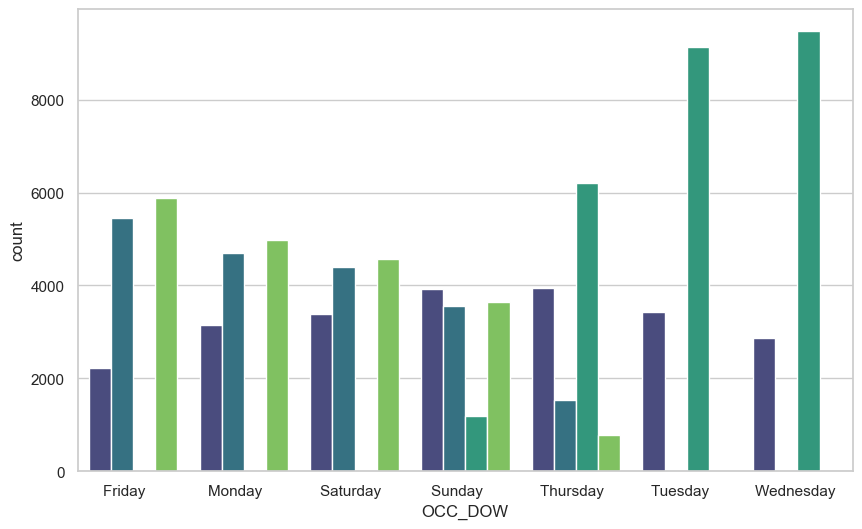

In [127]:
# Bar Plot of Cluster Distribution by Day of the Week
plt.figure(figsize=(10, 6))
sns.countplot(x='OCC_DOW', hue='Time_Cluster', data=crime_data, palette='viridis', order=label_encoder_dow.classes_)
plt.title('Cluster Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Time Cluster')
plt.xticks(rotation=45)
plt.show()

In [128]:
# Reapply label encoding for the original categorical 'OCC_MONTH'
crime_data['OCC_MONTH_encoded'] = label_encoder_month.fit_transform(crime_data['OCC_MONTH'])

# Check if the Time_Cluster column exists and has been populated correctly
crime_data[['OCC_MONTH', 'OCC_MONTH_encoded', 'Time_Cluster']].head()

,OCC_MONTH,OCC_MONTH_encoded,Time_Cluster
0,December,2,2
1,January,4,0
2,December,2,2
3,December,2,2
4,December,2,2


/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/autumninmarch/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


AttributeError: 'numpy.int32' object has no attribute 'startswith'

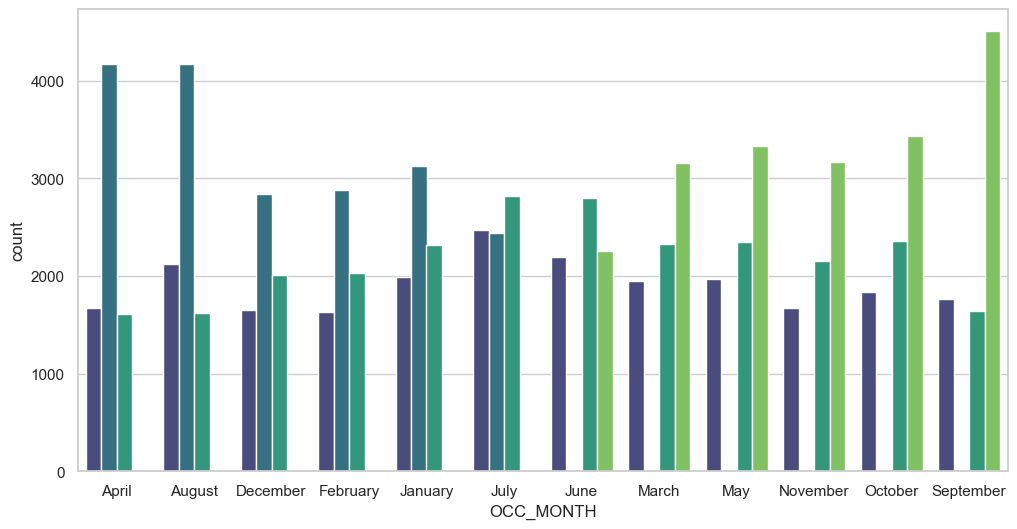

In [129]:
# Plotting the cluster distribution by month of the year
plt.figure(figsize=(12, 6))
sns.countplot(x='OCC_MONTH', hue='Time_Cluster', data=crime_data, palette='viridis', order=label_encoder_month.classes_)
plt.title('Cluster Distribution by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Count')
plt.legend(title='Time Cluster')
plt.xticks(rotation=45)
plt.show()

##### Evaluate the model

In [130]:
# Calculating Silhouette Index
silhouette_avg = silhouette_score(time_clustering_scaled, time_clusters)

silhouette_avg

0.2790756454332239

### Time Series Analysis

##### Forecasting future values

In [50]:
# Set OCC_DATE as the index
crime_data.set_index('OCC_DATE', inplace=True)

# Resample the data to get monthly counts
monthly_data = crime_data.resample('M').size()

# Display the first few rows of the aggregated data
monthly_data.head()

OCC_DATE
2000-01-31 00:00:00+00:00    1
2000-02-29 00:00:00+00:00    0
2000-03-31 00:00:00+00:00    0
2000-04-30 00:00:00+00:00    0
2000-05-31 00:00:00+00:00    0
Freq: M, dtype: int64

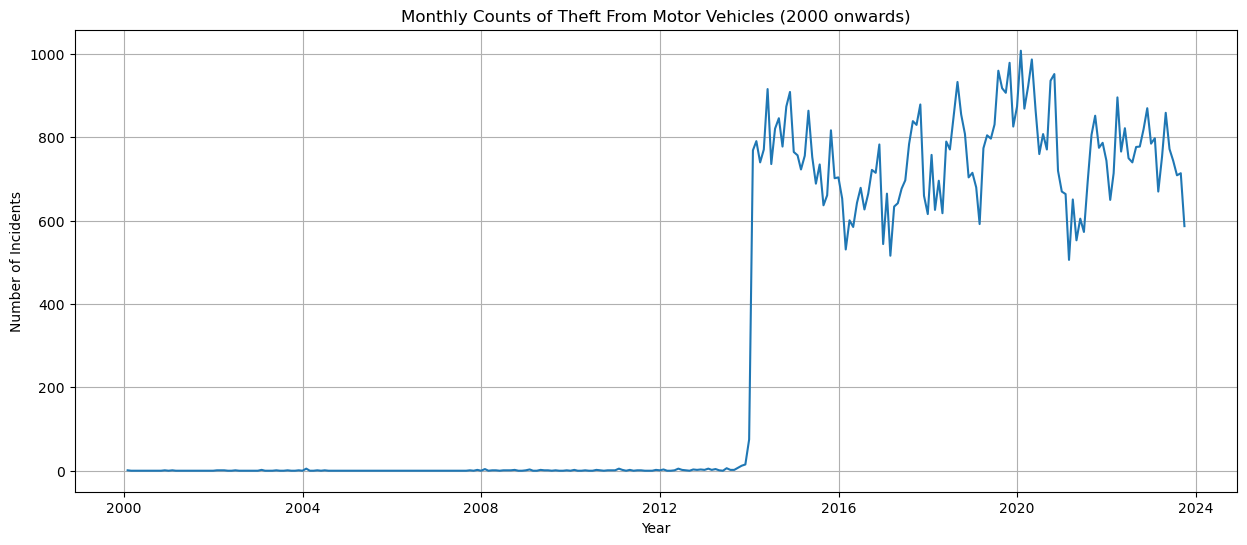

In [51]:
# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(monthly_data)
plt.title('Monthly Counts of Theft From Motor Vehicles (2000 onwards)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

In [54]:
# Calculate the annual total number of incidents to identify a more consistent start year
annual_totals = monthly_data.resample('Y').sum()
annual_totals

OCC_DATE
2000-12-31 00:00:00+00:00        2
2001-12-31 00:00:00+00:00        1
2002-12-31 00:00:00+00:00        4
2003-12-31 00:00:00+00:00        5
2004-12-31 00:00:00+00:00        7
2005-12-31 00:00:00+00:00        0
2006-12-31 00:00:00+00:00        0
2007-12-31 00:00:00+00:00        3
2008-12-31 00:00:00+00:00       12
2009-12-31 00:00:00+00:00        9
2010-12-31 00:00:00+00:00        9
2011-12-31 00:00:00+00:00       14
2012-12-31 00:00:00+00:00       22
2013-12-31 00:00:00+00:00      131
2014-12-31 00:00:00+00:00     9716
2015-12-31 00:00:00+00:00     8798
2016-12-31 00:00:00+00:00     7748
2017-12-31 00:00:00+00:00     8439
2018-12-31 00:00:00+00:00     9126
2019-12-31 00:00:00+00:00     9943
2020-12-31 00:00:00+00:00    10268
2021-12-31 00:00:00+00:00     8211
2022-12-31 00:00:00+00:00     9368
2023-12-31 00:00:00+00:00     6607
Freq: A-DEC, dtype: int64

In [55]:
# Find the first year where the annual total exceeds a certain threshold
# This threshold is arbitrarily set for demonstration and may need adjustment
threshold = 50  # Assuming a threshold of at least 50 incidents per year as an indicator of consistent data
consistent_start_year = annual_totals[annual_totals > threshold].index[0].year

consistent_start_year

2013

In [57]:
# Filter the data to include records from the year 2013 onwards
consistent_data = monthly_data[monthly_data.index.year >= 2013]

# Display the first few rows of the consistent data
consistent_data.head()

OCC_DATE
2013-01-31 00:00:00+00:00    5
2013-02-28 00:00:00+00:00    2
2013-03-31 00:00:00+00:00    4
2013-04-30 00:00:00+00:00    1
2013-05-31 00:00:00+00:00    0
Freq: M, dtype: int64

In [58]:
# Check for stationarity
result = adfuller(consistent_data)
adf_statistic = result[0]
p_value = result[1]

# Display the results
adf_statistic, p_value

(-3.3096776493626447, 0.014451386674494908)

In [59]:
# Splitting the data into train and test sets
train = consistent_data[:-12]  # All data except the last 12 months
test = consistent_data[-12:]   # The last 12 months

In [60]:
# Fit the SARIMA model on the training set
train_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
train_model_fit = train_model.fit()

# Summarize the model
train_model_summary = train_model_fit.summary()
train_model_summary

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30583D+00    |proj g|=  2.32391D-01

At iterate    5    f=  6.11046D+00    |proj g|=  4.66675D-03

At iterate   10    f=  6.10735D+00    |proj g|=  5.91763D-03

At iterate   15    f=  6.09660D+00    |proj g|=  3.25038D-02

At iterate   20    f=  6.09215D+00    |proj g|=  1.36222D-03

At iterate   25    f=  6.09025D+00    |proj g|=  2.07893D-02

At iterate   30    f=  6.08748D+00    |proj g|=  6.46997D-04

At iterate   35    f=  6.08733D+00    |proj g|=  6.99634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  117
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -712.204
Date:                            Mon, 04 Dec 2023   AIC                           1434.407
Time:                                    19:09:26   BIC                           1448.218
Sample:                                01-31-2013   HQIC                          1440.014
                                     - 09-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9763      0.019     50.917      0.000       0.939       1.014
ma.L1         -0.1060      0.110     -0.963      0.336      -0.322       0.110
ar.S.L12       0.8748      0.197      4.440      0.000       0.489       1.261
ma.S.L12      -0.7222      0.276     -2.621      0.009      -1.262      -0.182
sigma2      1.081e+04    899.796     12.012      0.000    9044.878    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               845.52
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             2.01
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Forecast for the next 12 months (the test set period)
forecast = train_model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=train.index[-1], periods=13, freq='M')[1:]
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

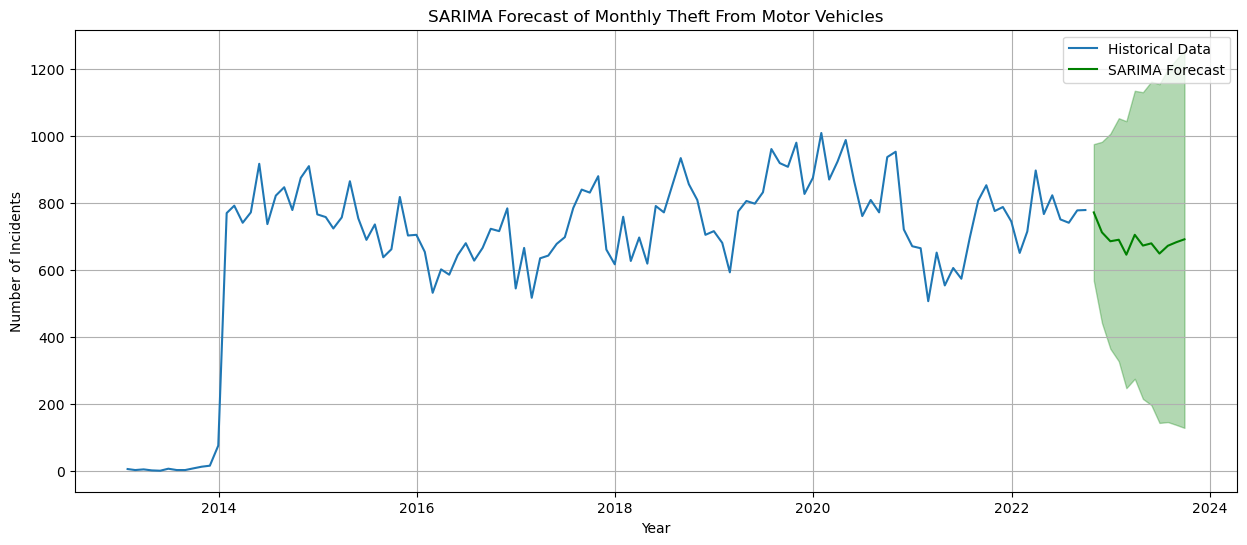

In [62]:
# Plotting the historical data and the SARIMA forecast
plt.figure(figsize=(15, 6))
plt.plot(train, label='Historical Data')
plt.plot(forecast_index, forecast_values, label='SARIMA Forecast', color='green')

# Plotting the confidence intervals for the SARIMA forecast
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='green', alpha=0.3)

plt.title('SARIMA Forecast of Monthly Theft From Motor Vehicles')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()

##### Evaluate the model

In [63]:
# Calculate evaluation metrics
mae = mean_absolute_error(test, forecast_values)
mse = mean_squared_error(test, forecast_values)
rmse = sqrt(mse)

# Print the evaluation metrics
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 86.78013908903283
Mean Squared Error: 9885.521068742846
Root Mean Squared Error: 99.42595772102398


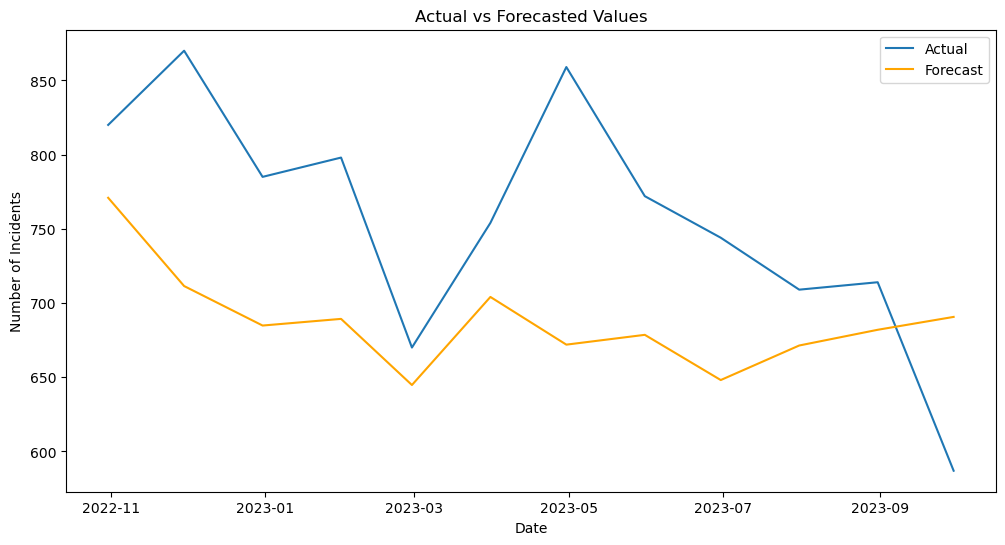

In [64]:
# Plotting the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(forecast_values, label='Forecast', color='orange')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.show()

### Random Forest Model

In [66]:
# Define the target column
crime_data['TARGET_COLUMN'] = (crime_data['MCI_CATEGORY'] == 'Theft Over').astype(int)
y = crime_data['TARGET_COLUMN']

In [67]:
# Select feature columns
# Building RF Model with certain feature selected variables
selected_columns = ['REPORT_HOUR', 'REPORT_DOW', 'LOCATION_TYPE', 'NEIGHBOURHOOD_158', 'OCC_HOUR', 'OCC_DOW']
X = crime_data[selected_columns]

In [68]:
# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['REPORT_DOW', 'LOCATION_TYPE', 'NEIGHBOURHOOD_158', 'OCC_DOW'], drop_first=True)

In [69]:
# Split the data into training and testing sets with a 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [71]:
# Check class distribution before and after SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("\nClass distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Class distribution before SMOTE:
 TARGET_COLUMN
0    59795
1     2115
Name: count, dtype: int64

Class distribution after SMOTE:
 TARGET_COLUMN
0    59795
1    59795
Name: count, dtype: int64


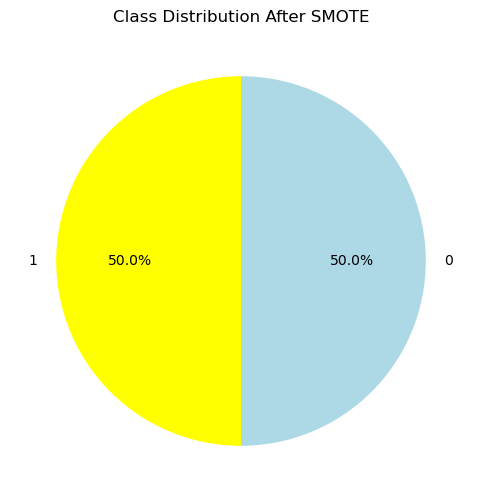

In [73]:
# Plotting the pie chart after SMOTE
plt.figure(figsize=(6, 6))

# Class distribution after SMOTE
class_distribution_after_smote = pd.Series(y_resampled).value_counts()

plt.pie(class_distribution_after_smote, labels=class_distribution_after_smote.index, autopct='%1.1f%%', startangle=90, counterclock=False, colors=['lightblue', 'yellow'])
plt.title('Class Distribution After SMOTE')

plt.show()

In [74]:
# Build and train the Random Forest model on the resampled data
model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=2)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_leaf=2, random_state=42)

In [76]:
# Make predictions on the training set
y_pred_train = model.predict(X_resampled)

# Confusion Matrix for training set
conf_matrix_train = confusion_matrix(y_resampled, y_pred_train)
print("Confusion Matrix (Train):\n", conf_matrix_train)

Confusion Matrix (Train):
 [[55887  3908]
 [ 4165 55630]]


In [77]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test):\n", conf_matrix_test)

Confusion Matrix (Test):
 [[23397  2268]
 [  777    91]]


In [78]:
# Check the class distribution of the predicted values for the test set
print("Predicted class distribution (Test):\n", pd.Series(y_pred_test).value_counts())

Predicted class distribution (Test):
 0    24174
1     2359
Name: count, dtype: int64


##### Evaluate the model

In [79]:
# Evaluate the model on the original (unbalanced) test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy (Test): {accuracy_test}")

# Display classification report for additional evaluation metrics for the test set
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test))

Accuracy (Test): 0.8852372517242679

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.97      0.91      0.94     25665
           1       0.04      0.10      0.06       868

    accuracy                           0.89     26533
   macro avg       0.50      0.51      0.50     26533
weighted avg       0.94      0.89      0.91     26533

